In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy
import scipy.constants as co
import scipy.stats as ss
from scipy.ndimage import shift
import itertools
import pickle

from lmfit.models import GaussianModel, LinearModel

In [2]:
import pickle
#how to read
#fileObj = open('data/r76-80V-naitrig-100eV-goodchi.pkl', 'rb')
fileObj = open('data/r76_events_coincidencepeak.pkl', 'rb')
exampleObj = pickle.load(fileObj)
fileObj.close()
#print(exampleObj)

In [3]:
import statistics as st
def isRailed(v):
    if(np.isnan(v).any()):
        return True
    if(st.mode(v)==0):
        return True
    return False

In [4]:
#import singularity_pulseSave as sps
import pulseAnalysis as pa

pulse_struct = pa.parseEventList('../coin_analysis/data/r76-coinpeak-gt-50keV.txt')

   SeriesNumber  EventNumber
0   72209162200        30273
1   72209162200        70006
2   72209162200        80047
3   72209162200       100850
4   72209162200       110307
5   72209162200       130025
6   72209162200       150876
7   72209162200       160028
8   72209162200       170463
9   72209162200       180787
[72209162200 72209171225 72209172155]
[  30273   70006   80047  100850  110307  130025  150876  160028  170463
  180787  190079  220095  230127  230377  230775  250878  270133  280450
  290139  290301  300773  330520  330924  340147  340705  370726  380017
  410662  430050  430054  440388  450132  460753  460821  470097  480651
  490274  510691  540114  540466  550020  550628  580010  580133  580227
  610367  610447  620766  630735  670014  670095  670140  680194  680395
  680651  680857  690650  690744  700105  720006  720467  770005  780005
  780122  780170  780377  780430  790907  800793  820330  830348  850764
  870886  880263  890099  890305  890719  900814  910136  9

In [5]:
coindata = pd.read_csv("../coin_analysis/data/r76_events_coincidencepeak.txt", skiprows=3, engine='python',skipfooter=1,sep="*",skipinitialspace=True, \
            index_col=False, \
            names=['garbage','Row','SeriesNumber','EventNumber','PTOFdelay','pt_keVee'], \
            delim_whitespace=False)

series_nums = np.asarray(coindata['SeriesNumber'])
event_nums = np.asarray(coindata['EventNumber'])
EkeV = np.asarray(coindata['pt_keVee'])
PTOFdelay = np.asarray(coindata['PTOFdelay'])

def getEnergy(series,ev):
    energy = 0

    for i in range(0, len(series_nums)):
        if series_nums[i] == series:
            if event_nums[i] == ev:
                energy = (EkeV[i])
    return energy

def getBaseline(ptpulse):
    
    x = np.linspace(100, 250, 150)
    #print(len(x))
    y = ptpulse[100:250]
    #print(len(y))
    
    #print(x)
    #print(y)
    
    baseline_model = np.polyfit(x, y, 1)
    baseline_model_fn = np.poly1d(baseline_model)
    
    return(baseline_model_fn)

In [6]:
# toggle plotting pulses
plot = True

### Constant Fraction Discriminator 

In [7]:
def getPTPulseCFD(pulses,series=72209162200,ev=30273,chan=[('Z1','PA'),('Z1','PB'),('Z1','PD'),('Z3','PA'),('Z3','PB'),('Z3','PD')]):
    ptpulse=[]
    ccount=0
    for c in chan:
        #print(c[0])
        pulse = pulses[c[0]][c[1]][series,ev]
        if(isRailed(pulse)):
            continue
        mean = np.mean(pulse[100:])
        pulse = pulse-mean
        
        #CFD formula
        F = 0.1
        D = 100
        CFD = F*(pulse)-(pulse-D)

        end_values = pulse[3997:]
        #print(end_values)
        new_pulse = shift(pulse,100,cval=np.nan)
        #print(new_pulse)
        
        #adding the cut off values to the front of the new pulse
        new_pulse[0:99] = end_values
        #print(new_pulse)
        
        CFD_pulse = F*(new_pulse)-new_pulse
        
        if(ccount==0):
            ptpulse=CFD_pulse
        else:
            ptpulse+=CFD_pulse
        ccount+=1

    #print(ptpulse)
    return ptpulse

In [8]:
getPTPulseCFD(exampleObj)

array([1020.16734234, 1020.16734234, 1019.26734234, ..., 1022.86734234,
       1020.16734234, 1022.86734234])

Series Number: 72209171225
Event Number: 1640584
Energy: 50.03925738139 keV


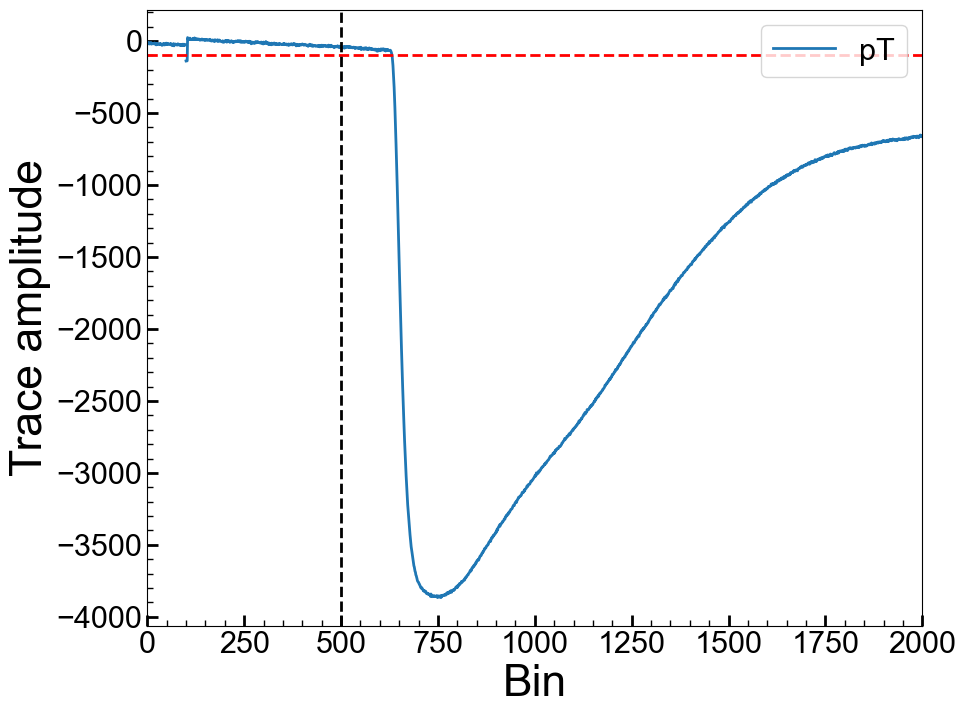

Series Number: 72209171225
Event Number: 2540077
Energy: 50.16777996411 keV


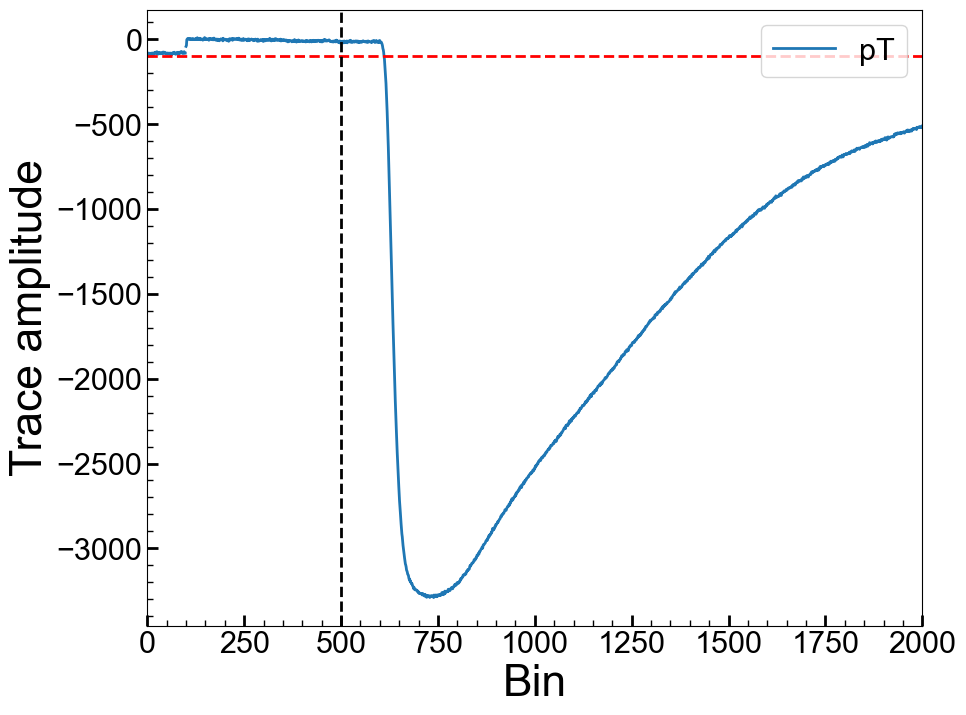

Series Number: 72209171225
Event Number: 2830896
Energy: 50.17418206142 keV


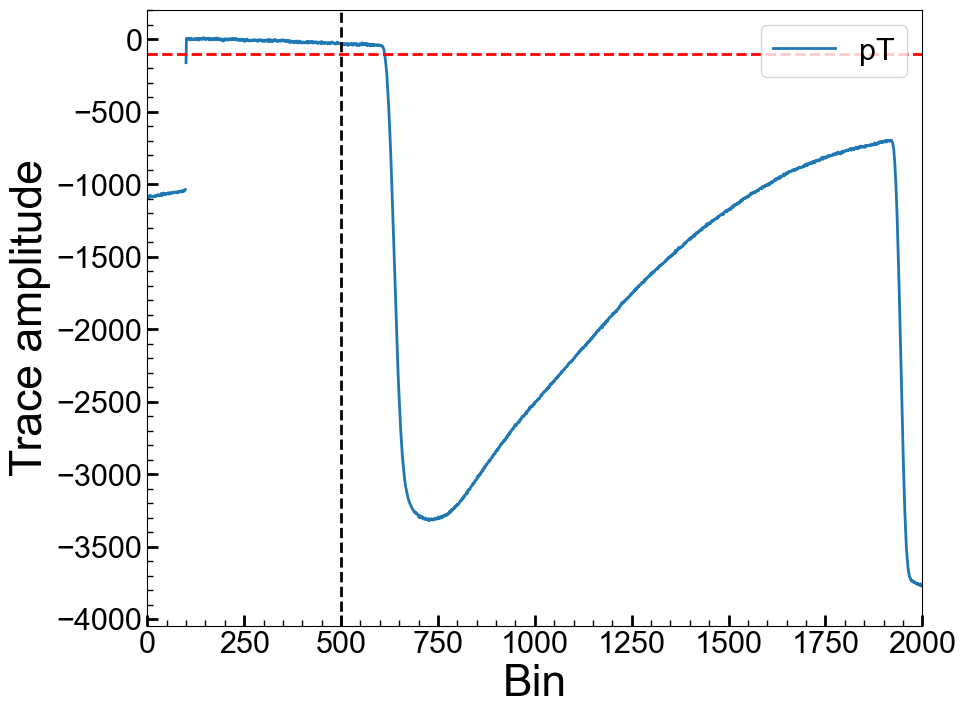

Series Number: 72209172155
Event Number: 1320413
Energy: 50.04938474864 keV


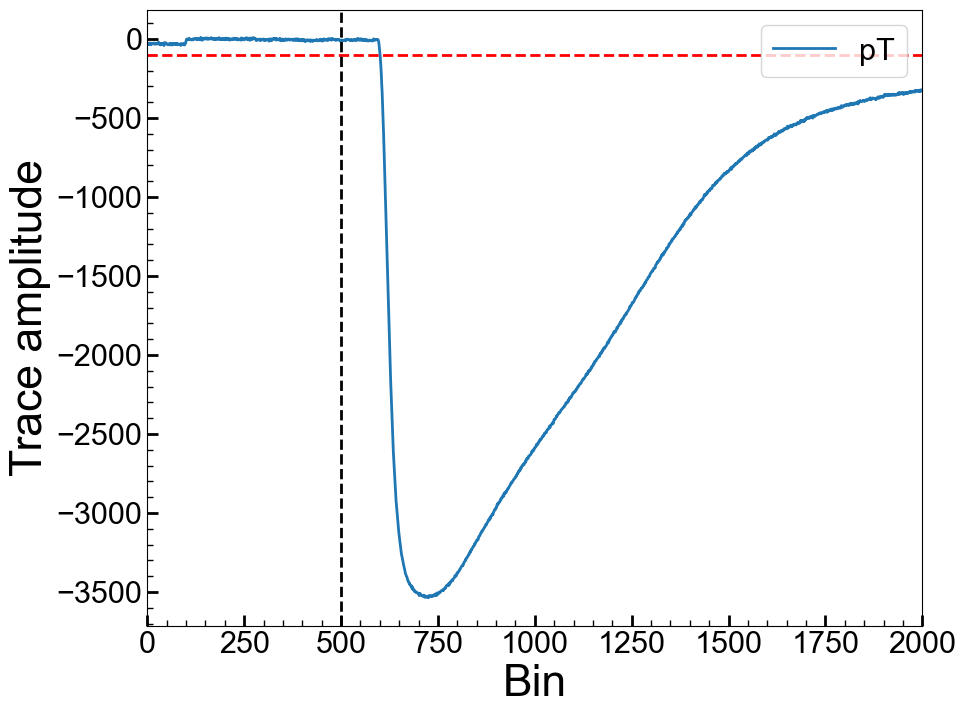

In [10]:
loops = 0
time_cfd = []
energies = []

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:

        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        if energy > 50.3:
            continue
    
        shownpulses=0

        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCFD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        
        bshifted_pT = np.subtract(pT,yB)

        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, -100, atol=30.0)
            
            #t = 0
            for i in range(0,750):
                if (crosses[i] == True):
                    time_cfd.append(i)
                    #print("Crosses at bin: " + str(i))
                    energies.append(energy)
                    #t += 1
                    break
                    
                    
            if (plot==True):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(np.subtract(pT, yB), label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=-100, color='r', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,2000)
                #ax1.set_ylim(-10,10)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")

                #plt.suptitle('Event 0 on Z1 PA Channels')
                if(shownpulses > 0):
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            loops += 1